2025-12-08 19:21:23.933602: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 19:21:23.939075: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 19:21:24.146497: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 19:21:25.102048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

1. Loading Data...
2. Performing MSTL Decomposition for Baselines...
Train samples: 5833, Test samples:  649
--------------------------------------------------
Running Polynomial Trend + Seasonal Naive...
Running ARIMA (5,1,0)...
Running Complex LSTM (128 Units + Dropout)...


E0000 00:00:1765201907.190790    8390 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765201907.197655    8390 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Running ELM (Paper Config: 25 Neurons)...

MODEL                     | RMSE         | MAE          | MAPE (%)  
---------------------------------------------------------------------------
Poly_Seasonal_Naive       | 79.5337      | 71.0681      | 29.03     
ARIMA                     | 106.7680     | 79.6794      | 25.90     
Complex_LSTM              | 13.8454      | 9.9136       | 3.25      
ELM_Paper                 | 36.6098      | 23.4175      | 7.12      


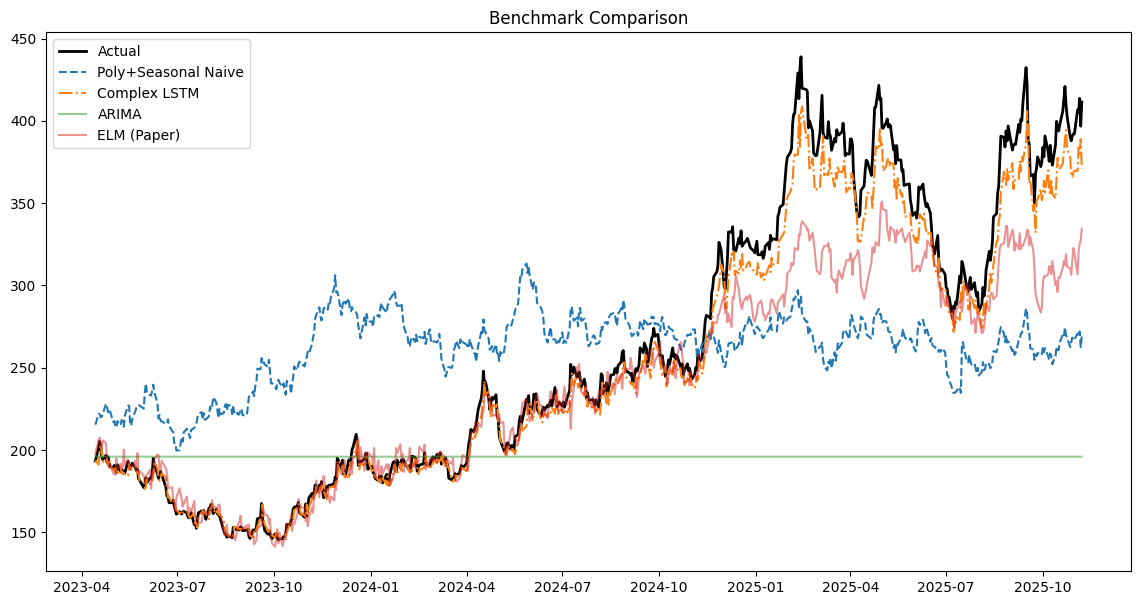

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import MSTL
from scipy.linalg import pinv
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
tf.random.set_seed(42)
np.random.seed(42)

DATA_PATH = 'full_stock_data.csv'
TRAIN_RATIO = 0.90
TIME_STEP = 60
PERIODS = [143, 687, 3200]
EPOCHS = 30
BATCH_SIZE = 32

print("1. Loading Data...")
try:
    df = pd.read_csv(DATA_PATH, parse_dates=['Date'], index_col='Date')
except FileNotFoundError:
    df = pd.read_csv('coffee_data.csv', parse_dates=['Date'], index_col='Date')

df = df.sort_index().dropna(subset=['Close'])
y = df['Close']

print("2. Performing MSTL Decomposition for Baselines...")
stl = MSTL(y, periods=PERIODS, iterate=2).fit()
components = {
    'Trend': stl.trend,
    'S_143': stl.seasonal['seasonal_143'],
    'S_687': stl.seasonal['seasonal_687'],
    'S_3200': stl.seasonal['seasonal_3200'],
    'Residual': stl.resid
}

common_index = stl.trend.dropna().index
y_aligned = y.loc[common_index]

train_len = int(len(common_index) * TRAIN_RATIO)
train_idx = common_index[:train_len]
test_idx = common_index[train_len:]
forecast_horizon = len(test_idx)

print(f"Train samples: {len(train_idx)}, Test samples:  {len(test_idx)}")
print("-" * 50)

print("Running Polynomial Trend + Seasonal Naive...")

trend_train = components['Trend'].loc[train_idx].values
X_trend_train = np.arange(len(trend_train)).reshape(-1, 1)
X_trend_test = np.arange(len(trend_train), len(trend_train) + forecast_horizon).reshape(-1, 1)

poly_reg = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_reg.fit(X_trend_train, trend_train)
trend_pred = poly_reg.predict(X_trend_test)

def seasonal_naive_forecast(series, period, horizon):
    train_seq = series.loc[train_idx].values
    last_cycle = train_seq[-period:]
    num_repeats = int(np.ceil(horizon / period))
    return np.tile(last_cycle, num_repeats)[:horizon]

s143_pred = seasonal_naive_forecast(components['S_143'], 143, forecast_horizon)
s687_pred = seasonal_naive_forecast(components['S_687'], 687, forecast_horizon)
s3200_pred = seasonal_naive_forecast(components['S_3200'], 3200, forecast_horizon)

poly_seasonal_naive_preds = trend_pred + s143_pred + s687_pred + s3200_pred

print("Running ARIMA (5,1,0)...")
y_train_raw = y_aligned.loc[train_idx]
y_test_raw = y_aligned.loc[test_idx]

arima_model = ARIMA(y_train_raw, order=(5,1,0))
arima_fit = arima_model.fit()
arima_preds = arima_fit.forecast(steps=forecast_horizon).values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(y_aligned.values.reshape(-1, 1))

train_scaled = scaled_data[:train_len]
test_scaled = scaled_data[train_len - TIME_STEP:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_scaled, TIME_STEP)
X_test, y_test = create_dataset(test_scaled, TIME_STEP)

X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Running Complex LSTM (128 Units + Dropout)...")
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True, input_shape=(TIME_STEP, 1)),
    keras.layers.LSTM(128, return_sequences=False),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)

lstm_preds_scaled = lstm_model.predict(X_test_lstm, verbose=0)
lstm_preds = scaler.inverse_transform(lstm_preds_scaled).flatten()

print("Running ELM (Paper Config: 25 Neurons)...")
class ELMRegressor:
    def __init__(self, n_hidden_units=25):
        self.n_hidden_units = n_hidden_units
        self.input_weights = None
        self.biases = None
        self.output_weights = None

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.input_weights = np.random.normal(size=(n_features, self.n_hidden_units))
        self.biases = np.random.normal(size=(self.n_hidden_units,))
        H = self._sigmoid(np.dot(X, self.input_weights) + self.biases)
        self.output_weights = np.dot(pinv(H), y)

    def predict(self, X):
        H = self._sigmoid(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.output_weights)

elm_model = ELMRegressor(n_hidden_units=25)
elm_model.fit(X_train, y_train)
elm_preds_scaled = elm_model.predict(X_test)
elm_preds = scaler.inverse_transform(elm_preds_scaled.reshape(-1, 1)).flatten()

results_df = pd.DataFrame({
    'Actual': y_test_raw.values,
    'Poly_Seasonal_Naive': poly_seasonal_naive_preds,
    'ARIMA': arima_preds,
    'Complex_LSTM': lstm_preds,
    'ELM_Paper': elm_preds
}, index=test_idx)

print("\n" + "="*75)
print(f"{'MODEL':<25} | {'RMSE':<12} | {'MAE':<12} | {'MAPE (%)':<10}")
print("-" * 75)

models = ['Poly_Seasonal_Naive', 'ARIMA', 'Complex_LSTM', 'ELM_Paper']
for m in models:
    rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df[m]))
    mae = mean_absolute_error(results_df['Actual'], results_df[m])
    mape = np.mean(np.abs((results_df['Actual'] - results_df[m]) / results_df['Actual'])) * 100
    print(f"{m:<25} | {rmse:<12.4f} | {mae:<12.4f} | {mape:<10.2f}")

print("="*75)

plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual', color='black', linewidth=2)
plt.plot(results_df.index, results_df['Poly_Seasonal_Naive'], label='Poly+Seasonal Naive', linestyle='--')
plt.plot(results_df.index, results_df['Complex_LSTM'], label='Complex LSTM', linestyle='-.')
plt.plot(results_df.index, results_df['ARIMA'], label='ARIMA', alpha=0.5)
plt.plot(results_df.index, results_df['ELM_Paper'], label='ELM (Paper)', alpha=0.5)
plt.title('Benchmark Comparison')
plt.legend()
plt.show()